In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Add the parent directory of 'src' to the Python path
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Longman phrase and anki deck generation
A more memorable way to learn the core vocabulary as defined in Longman Communications vocab lists, we take the vocab and use an LLM
to generate phrases using it.

## Longman 1000, 2000 and 3000 already provided
Enlish phrases for the longman vocab have already been created and can be found in the 'data' folder

In [32]:
from src.utils import get_longman_verb_vocab_dict
from src.phrase import generate_phrases_from_vocab_dict

file_path = '../data/longman-communication-3000.json'
vocab_dict = get_longman_verb_vocab_dict(file_path, "S3") #S1 = 1st 1000 words used in Speech, options are S1-3 and W1-3

In [ ]:
#uses LLM calls - it sometimes generates phrases terminated too early (e.g. Mind the pot on the), so advise you scan through and check

#english phrases only initially
longman_phrases = generate_phrases_from_vocab_dict(vocab_dict, max_iterations=15)

In [34]:
with open("../outputs/longman/longman_3000_phrases.txt", "w", encoding="utf-8") as f:
    for phrase in longman_phrases:
        f.write(phrase + "\n")

## Create an Anki deck from thoses phrases

Or, load one of the english Longman phrase lists in data/ already created and apply to your language

This function:
1. translates
2. generates audio using text to speech
3. packages up the text and audio into several anki decks (in batches), that can be imported into Anki.

The deck_name will is used to derive the deck_id and so despite there being several *.apkg files created, these will all merge successfully into the same deck


In [ ]:

from src.anki import create_anki_deck_from_english_phrase_list

_ = await create_anki_deck_from_english_phrase_list(longman_phrases[:3], deck_name="Longman 3000 - Swedish", anki_filename_prefix="longman_3000_swedish", batch_size=50)

In [42]:
from src.utils import create_image_generation_prompt


prompt = create_image_generation_prompt(longman_phrases[0])

In [ ]:
longman_phrases[0]

# Generate Images

In [3]:
from diffusers import DiffusionPipeline
import torch
import os

torch.cuda.empty_cache()
# Check CUDA availability
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    


y:\Python Scripts\audio-language-trainer\.venv\Lib\site-packages\transformers\utils\hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


CUDA available: True
CUDA device: NVIDIA GeForce RTX 2070


In [2]:
import torch
from diffusers import StableDiffusion3Pipeline

pipe = StableDiffusion3Pipeline.from_pretrained(
    "stabilityai/stable-diffusion-3-medium-diffusers",
    torch_dtype=torch.float16
)
pipe = pipe.to("cuda")
pipe.enable_attention_slicing()


Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
base_style = "children's book illustration, Axel Scheffler style, thick brushstrokes, colored pencil texture, expressive characters, bold outlines, textured shading, earthy color palette"
prompt = f"An exhausted engineer on a couch with a half-eaten pizza nearby. Next to the couch is a broken cooker with its parts scattered around, style: {base_style}"
# Test the pipeline
image = pipe(
    prompt,
    height=512,
    width=512,
    negative_prompt = "photorealistic, anime, manga, 3d, realistic, photograph, camera, hyperrealistic, cgi, 3d render, smooth, digital art, Disney, Pixar",
    num_inference_steps=28,
    guidance_scale=7.0
).images[0]

# Display or save the image
image.show()

  0%|          | 0/28 [00:00<?, ?it/s]

In [15]:

# if using torch < 2.0
# pipe.enable_xformers_memory_efficient_attention()
base_style = "children's book illustration, Axel Scheffler style, thick brushstrokes, colored pencil texture, expressive characters, bold outlines, textured shading, earthy color palette"
prompt = f"A bride on a balcony, looking at sunset over the horizon, tropical island, villa style: {base_style}"


In [ ]:

images = pipe(prompt=prompt).images[0]
images.show()


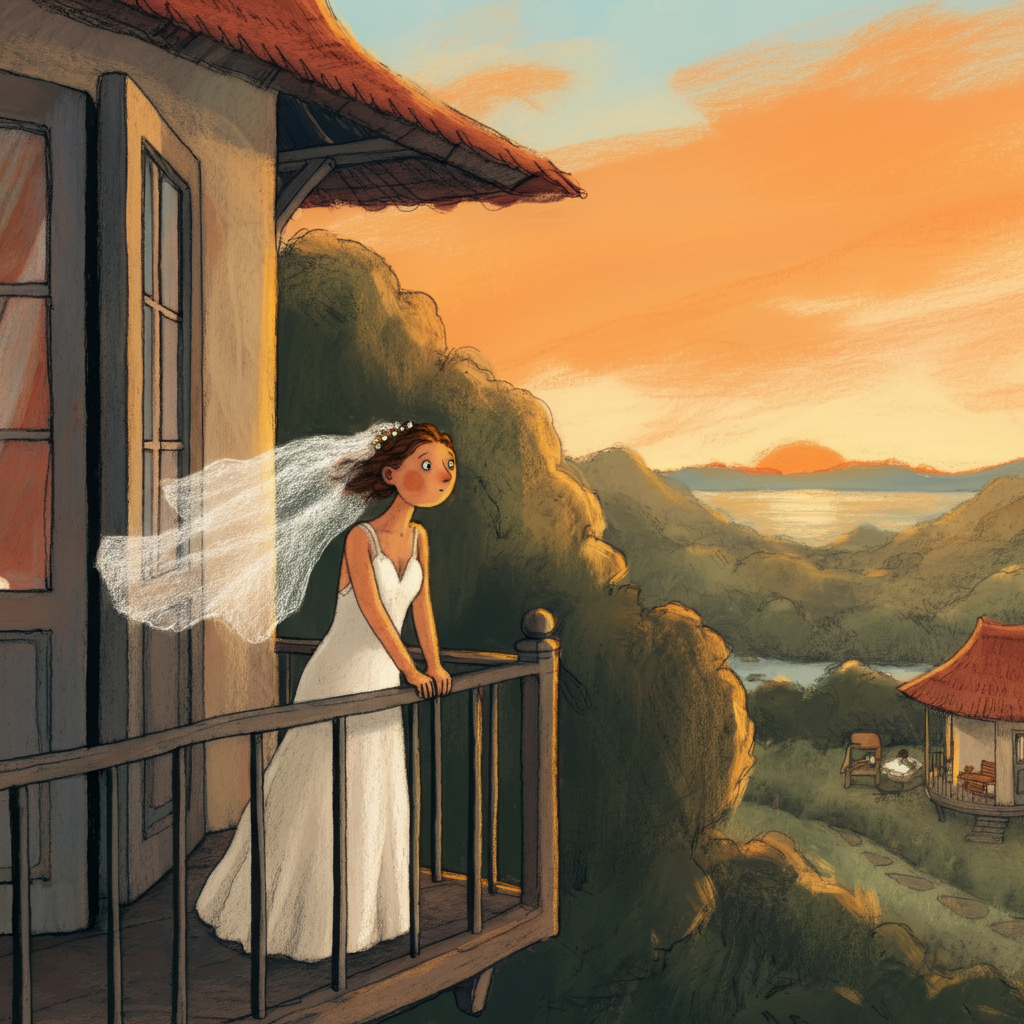

In [7]:
from src.utils import generate_image_imagen

im_image = generate_image_imagen(prompt, model="imagen-3.0-generate-001")
im_image.show()

In [9]:
im_image.save("bride.png")

In [7]:
from diffusers import DiffusionPipeline, EulerDiscreteScheduler

# Use a smaller, faster model
model_id = "stabilityai/stable-diffusion-2-1"  # Smaller than XL

# Load the pipeline with optimizations
pipe = DiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    use_safetensors=True,
)

# Move to GPU and enable memory efficient attention
pipe = pipe.to("cuda")
pipe.enable_attention_slicing()

# Use the Euler scheduler, which is faster than the default
pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)

# Optional: Enable torch.compile() for potential speedup (requires PyTorch 2.0 or later)
# Uncomment the next line if you're using PyTorch 2.0+
#pipe.unet = torch.compile(pipe.unet, mode="reduce-overhead", fullgraph=True)


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [16]:
image = pipe(
    prompt,
    height=512,
    width=512,
    #negative_prompt = "photorealistic, anime, manga, 3d, realistic, photograph, camera, hyperrealistic, cgi, 3d render, smooth, digital art, Disney, Pixar",
    num_inference_steps=50,
    guidance_scale=8
).images[0]


  0%|          | 0/50 [00:00<?, ?it/s]

In [17]:

# Display or save the image
image.save("SD2-1.png")


In [15]:
import os
from diffusers import StableDiffusionPipeline
import torch

# Suppress symlink warning
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

def download_model(model_id):
    print(f"Downloading {model_id}...")
    # Download only, don't load to GPU
    pipe = StableDiffusionPipeline.from_pretrained(
        model_id,
        torch_dtype=torch.float16,
        resume_download=True
    )
    print(f"✓ Downloaded {model_id}")

models = [
    #"sd-legacy/stable-diffusion-v1-5",
    #"stabilityai/stable-diffusion-2-1",
     "stabilityai/stable-diffusion-3-medium-diffusers",
    #"stabilityai/stable-diffusion-xl-base-1.0",
]

for model in models:
    download_model(model)

print("\nAll models downloaded!")

model_index.json:   0%|          | 0.00/706 [00:00<?, ?B/s]

Fetching 26 files:   0%|          | 0/26 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

text_encoder_3/config.json:   0%|          | 0.00/740 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/247M [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.53G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

(…)t_encoder_3/model.safetensors.index.json:   0%|          | 0.00/19.9k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/705 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/576 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

tokenizer_3/special_tokens_map.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer_3/tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

tokenizer_3/tokenizer_config.json:   0%|          | 0.00/20.6k [00:00<?, ?B/s]

transformer/config.json:   0%|          | 0.00/372 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/4.17G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/739 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

Keyword arguments {'resume_download': True} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/4 [00:00<?, ?it/s]

ValueError: Pipeline <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> expected {'safety_checker', 'text_encoder', 'vae', 'tokenizer', 'unet', 'feature_extractor', 'image_encoder', 'scheduler'}, but only {'vae', 'text_encoder', 'tokenizer', 'scheduler'} were passed.